In [1]:
import torch
from torch.autograd import Variable
from tqdm import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns


np.random.seed(42)



In [2]:
plt.rcParams["figure.figsize"] = (20,10)
sns.set_context("poster")
sns.set_style("ticks")

In [3]:
epochs = 10000

In [4]:
from models import SimpleModel

In [5]:
N = 100


In [6]:


def generate_data(datalen=1000,noise_level=0.2) -> np.array:
    """returns numpy arrays X and y that can be used as basis for regression problem"""

    #X = np.arange(0, self.datalen)
    X = np.linspace(0,300,datalen)

    freq1 = 0.2
    freq2 = 0.15

    freq1 = 0.1
    freq2 = 0.0375
    noise = np.random.randn(datalen) * noise_level
    
    def generate_y(X_):
        """nonlinear case"""
        y1 = np.sin(X_ * freq1) 
        y2 = np.sin(X_ * freq2) 
        return y1 + y2
    
    def generate_y_linear(X_):
        """linear case"""
        return X_/datalen
    
    y = generate_y(X) + noise
    

    
    padding = datalen/2
    
    X_long = np.insert(X,0,np.min(X)-padding)
    
    X_long = np.append(X_long,np.max(X)+padding)
    y_long = generate_y(X_long)
    
    X = (X - np.min(X_long)) / (np.max(X_long) - np.min(X_long))
    X_long = (X_long - np.min(X_long)) / (np.max(X_long) - np.min(X_long))

    return np.expand_dims(X.astype(np.float32),1), np.expand_dims(y.astype(np.float32),1), X_long, y_long



def generate_data(datalen=1000,noise_level=0.2,padding_size=10) -> np.array:
    """returns numpy arrays X and y that can be used as basis for regression problem"""
    
    X_long = np.linspace(0,1,datalen)
    X = X_long[padding_size:]
    X = X[:len(X) - padding_size]  
    

    #X = np.arange(0, self.datalen)
    #X = np.linspace(0,300,datalen)
    
    #padding = datalen/2
    X = np.insert(X,0,X_long[0])
    X = np.append(X,X_long[-1])
    #X_long = np.append(X_long,np.max(X)+padding)

    freq1 = 0.2
    freq2 = 0.15

    freq1 = 0.1
    freq2 = 0.0375
    noise = np.random.randn(len(X)) * noise_level
    
    def generate_y(X_):
        """nonlinear case"""
        X_ = X_ * 200
        y1 = np.sin(X_ * freq1) 
        y2 = np.sin(X_ * freq2) 
        return y1 + y2
    
    def generate_y_linear(X_):
        """linear case"""
        return X_/datalen
    
    y = generate_y(X) + noise
    y_long = generate_y(X_long)
    
    #X = (X - np.min(X_long)) / (np.max(X_long) - np.min(X_long))
    #X_long = (X_long - np.min(X_long)) / (np.max(X_long) - np.min(X_long))
    

    #return np.expand_dims(X.astype(np.float32),1), np.expand_dims(y.astype(np.float32),1), X_long, y_long
    #data_utils.TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(Y).float())

    return X, y, X_long, y_long

In [7]:
#[np.random.randn() for x in range(100)]

In [8]:
X,y,X_long,y_long = generate_data(N,0.3)

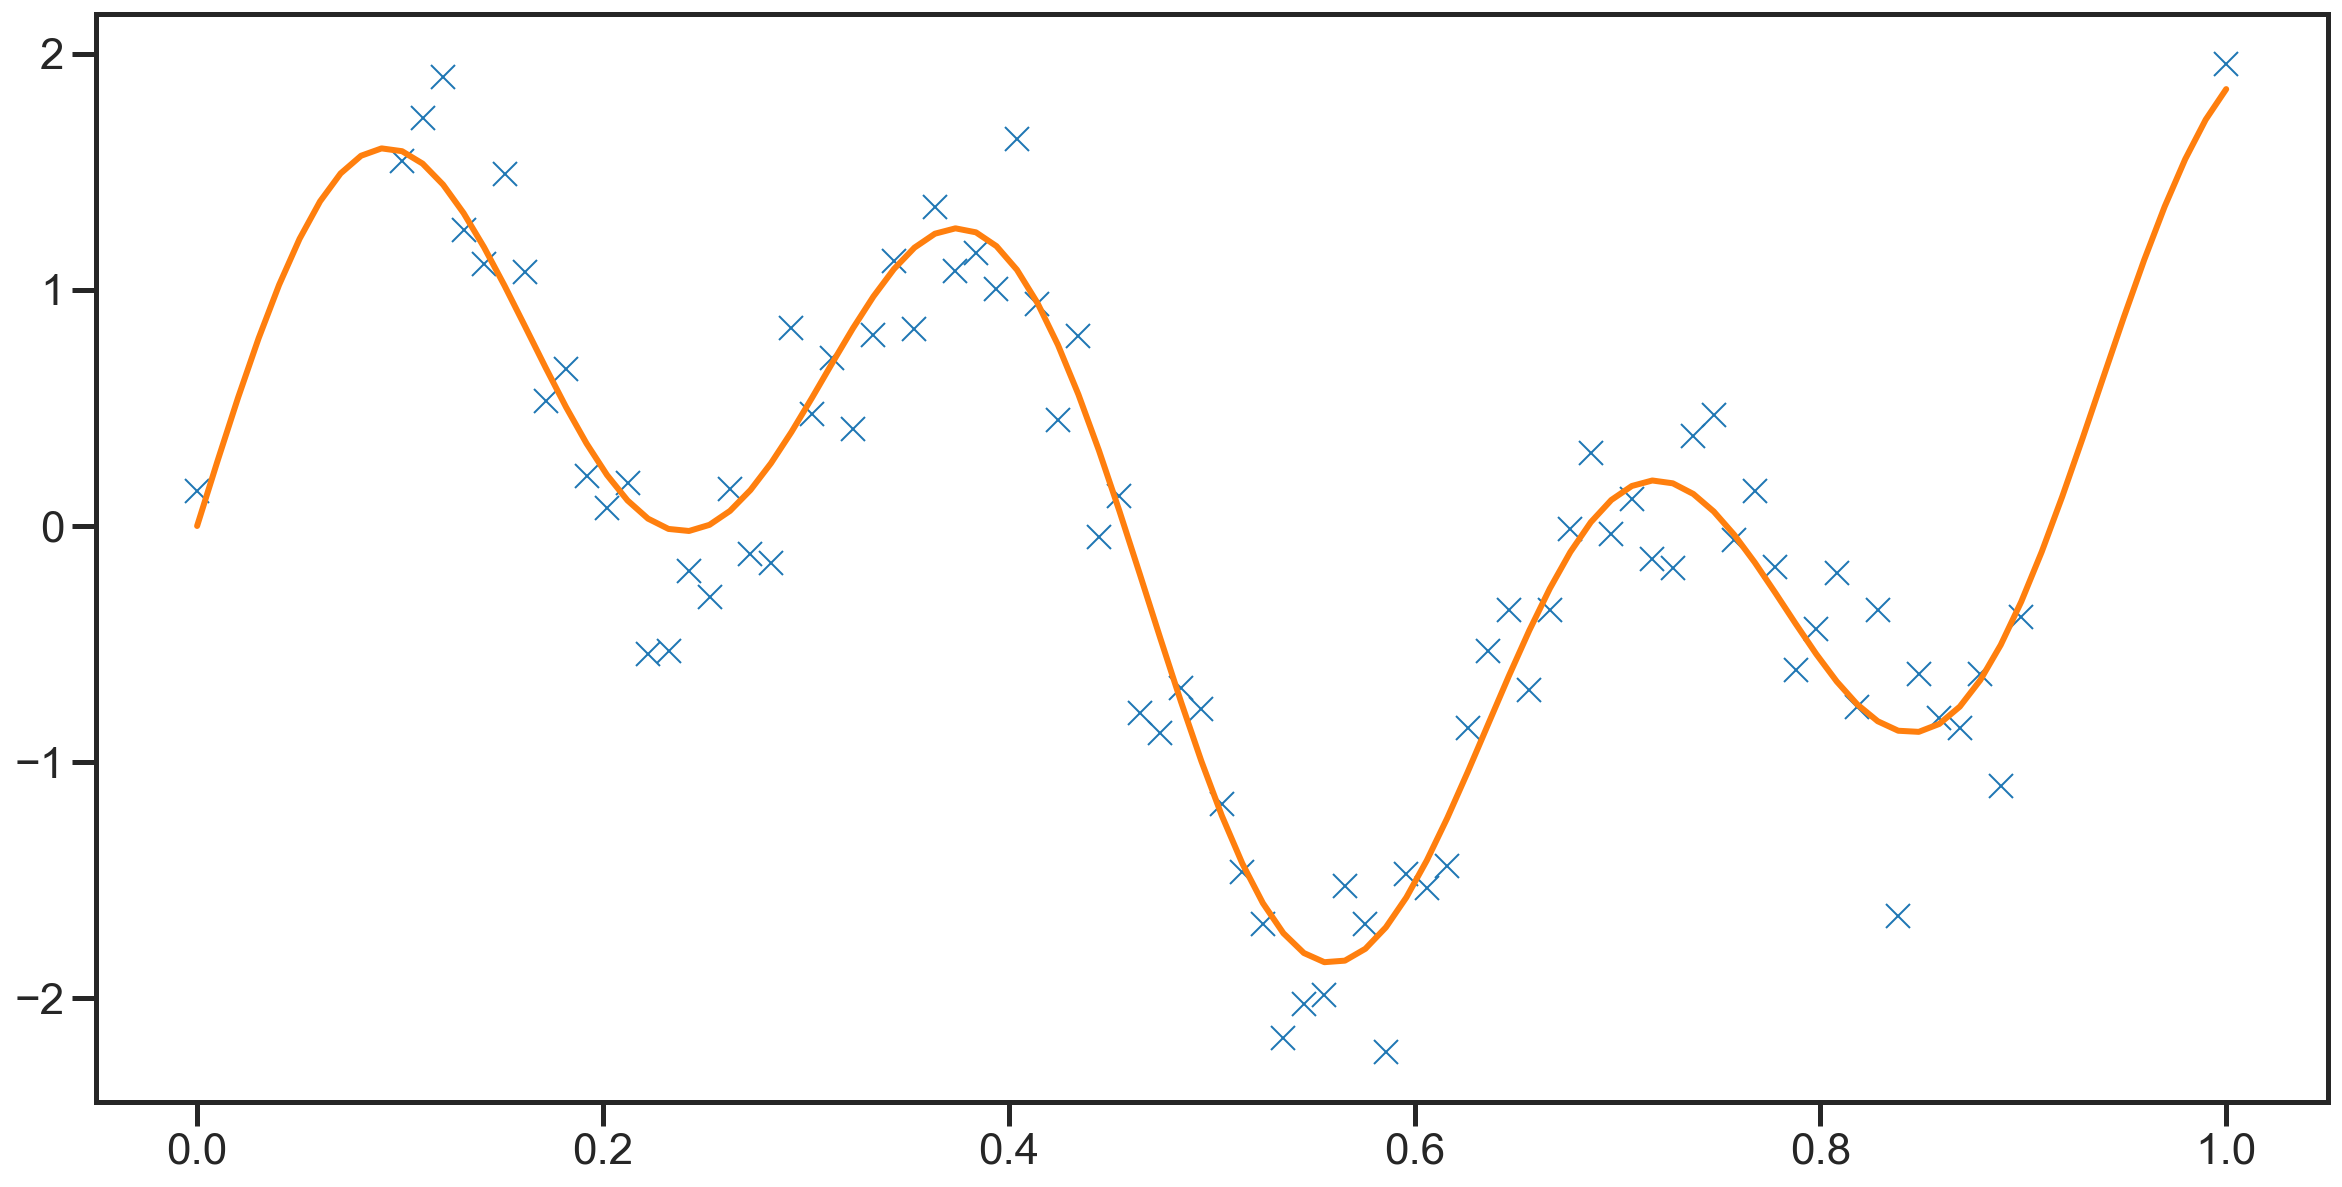

In [9]:
plt.plot(X,y,'x')
plt.plot(X_long,y_long)

In [10]:
model = SimpleModel()

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1639.48it/s]


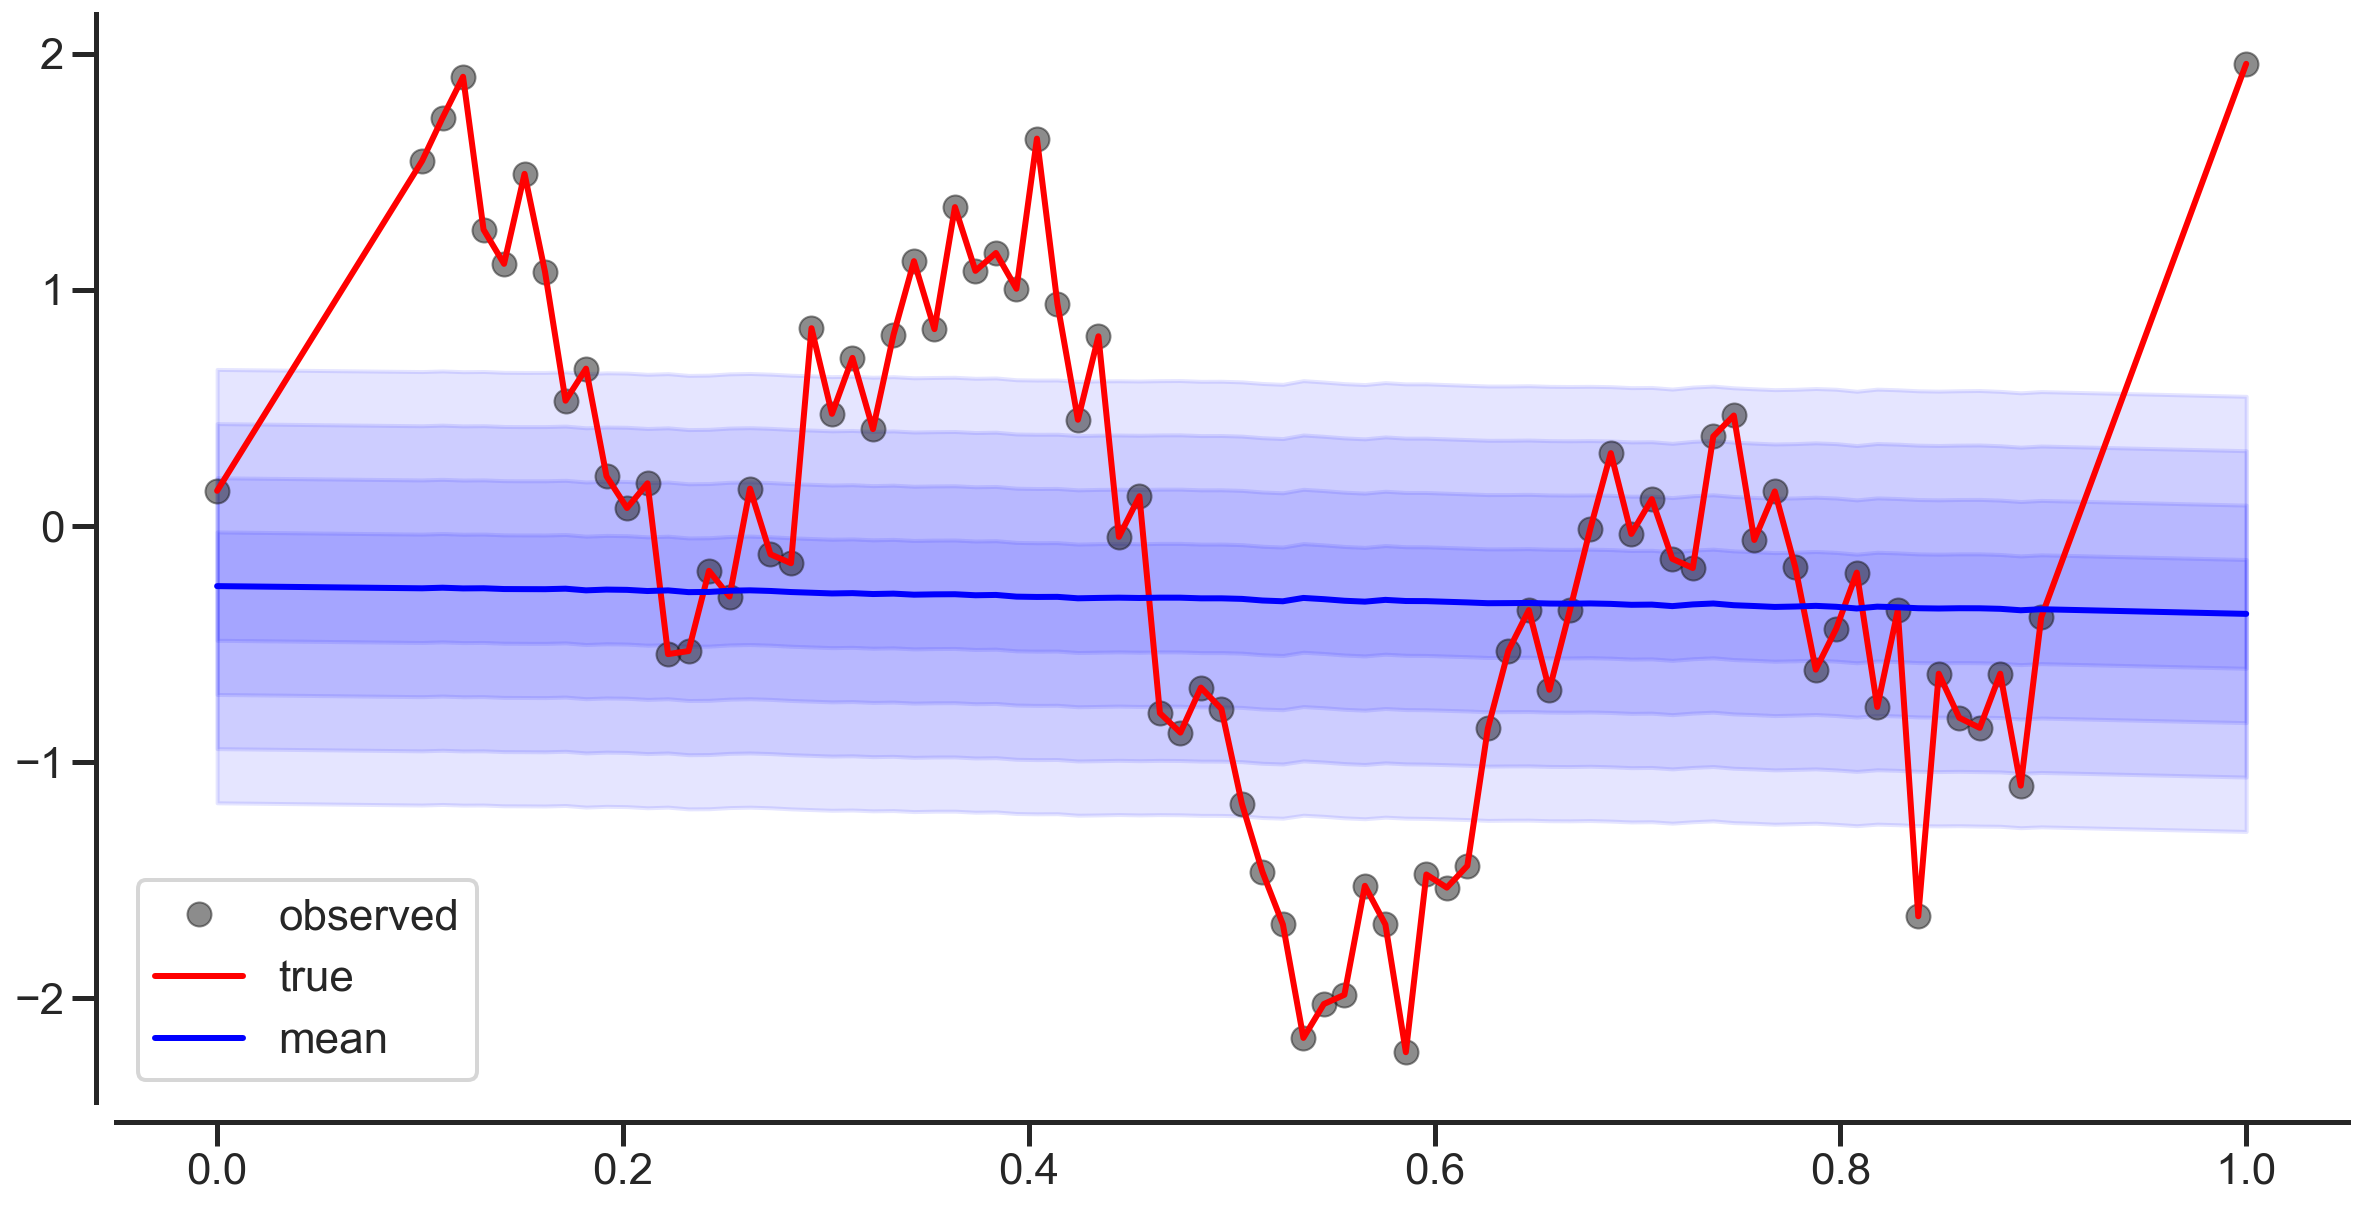

In [11]:

iters = 100
l2 = 1
n_std = 4


fig, ax = plt.subplots(1,1)
y_mean, y_std = model.uncertainty_function(X, iters, l2=l2)
    
ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X, y, ls="-", color="r", label="true")
ax.plot(X, y_mean, ls="-", color="b", label="mean")

for i in range(n_std):
    ax.fill_between(
        X.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
ax.legend()
sns.despine(offset=10)


In [12]:
%%time


for i in trange(epochs):

    model.fit_model(X,y)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.98it/s]


Wall time: 25.7 s


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1265.84it/s]


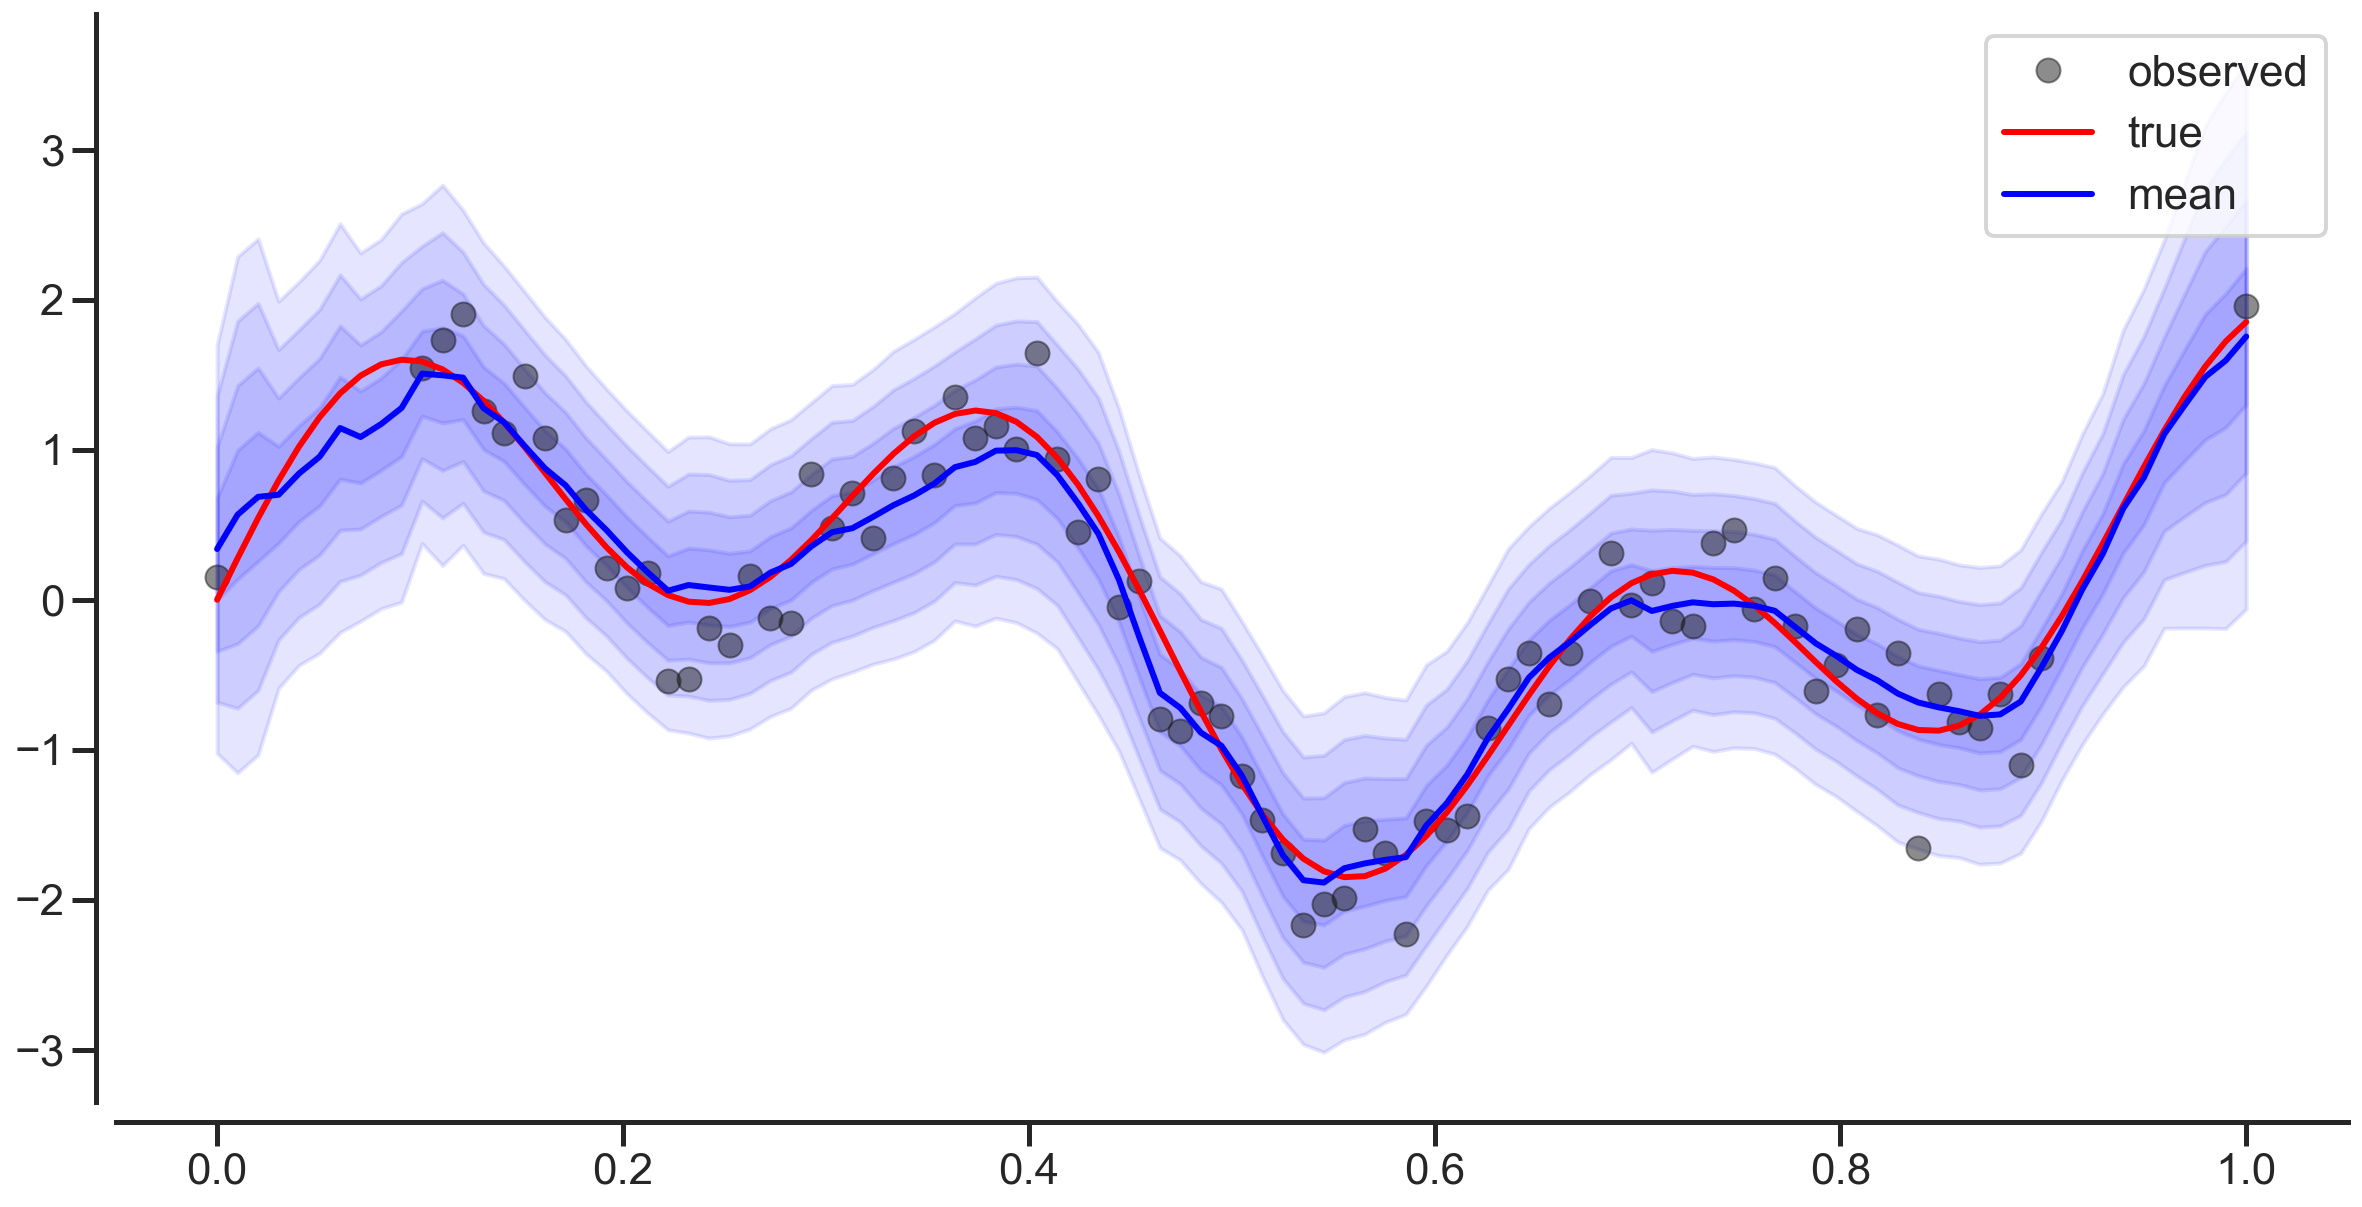

In [13]:

iters = 100
l2 = 1
n_std = 4


fig, ax = plt.subplots(1,1)
y_mean, y_std = model.uncertainty_function(X_long, iters, l2=l2)
y_mean_raw, y_std_raw = model.uncertainty_function(X_long, iters, l2=l2,raw_var=True)


ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_long, y_long, ls="-", color="r", label="true")
ax.plot(X_long, y_mean, ls="-", color="b", label="mean")

for i in range(n_std):
    ax.fill_between(
        X_long.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
    
    
    

ax.legend()
sns.despine(offset=10)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1492.57it/s]


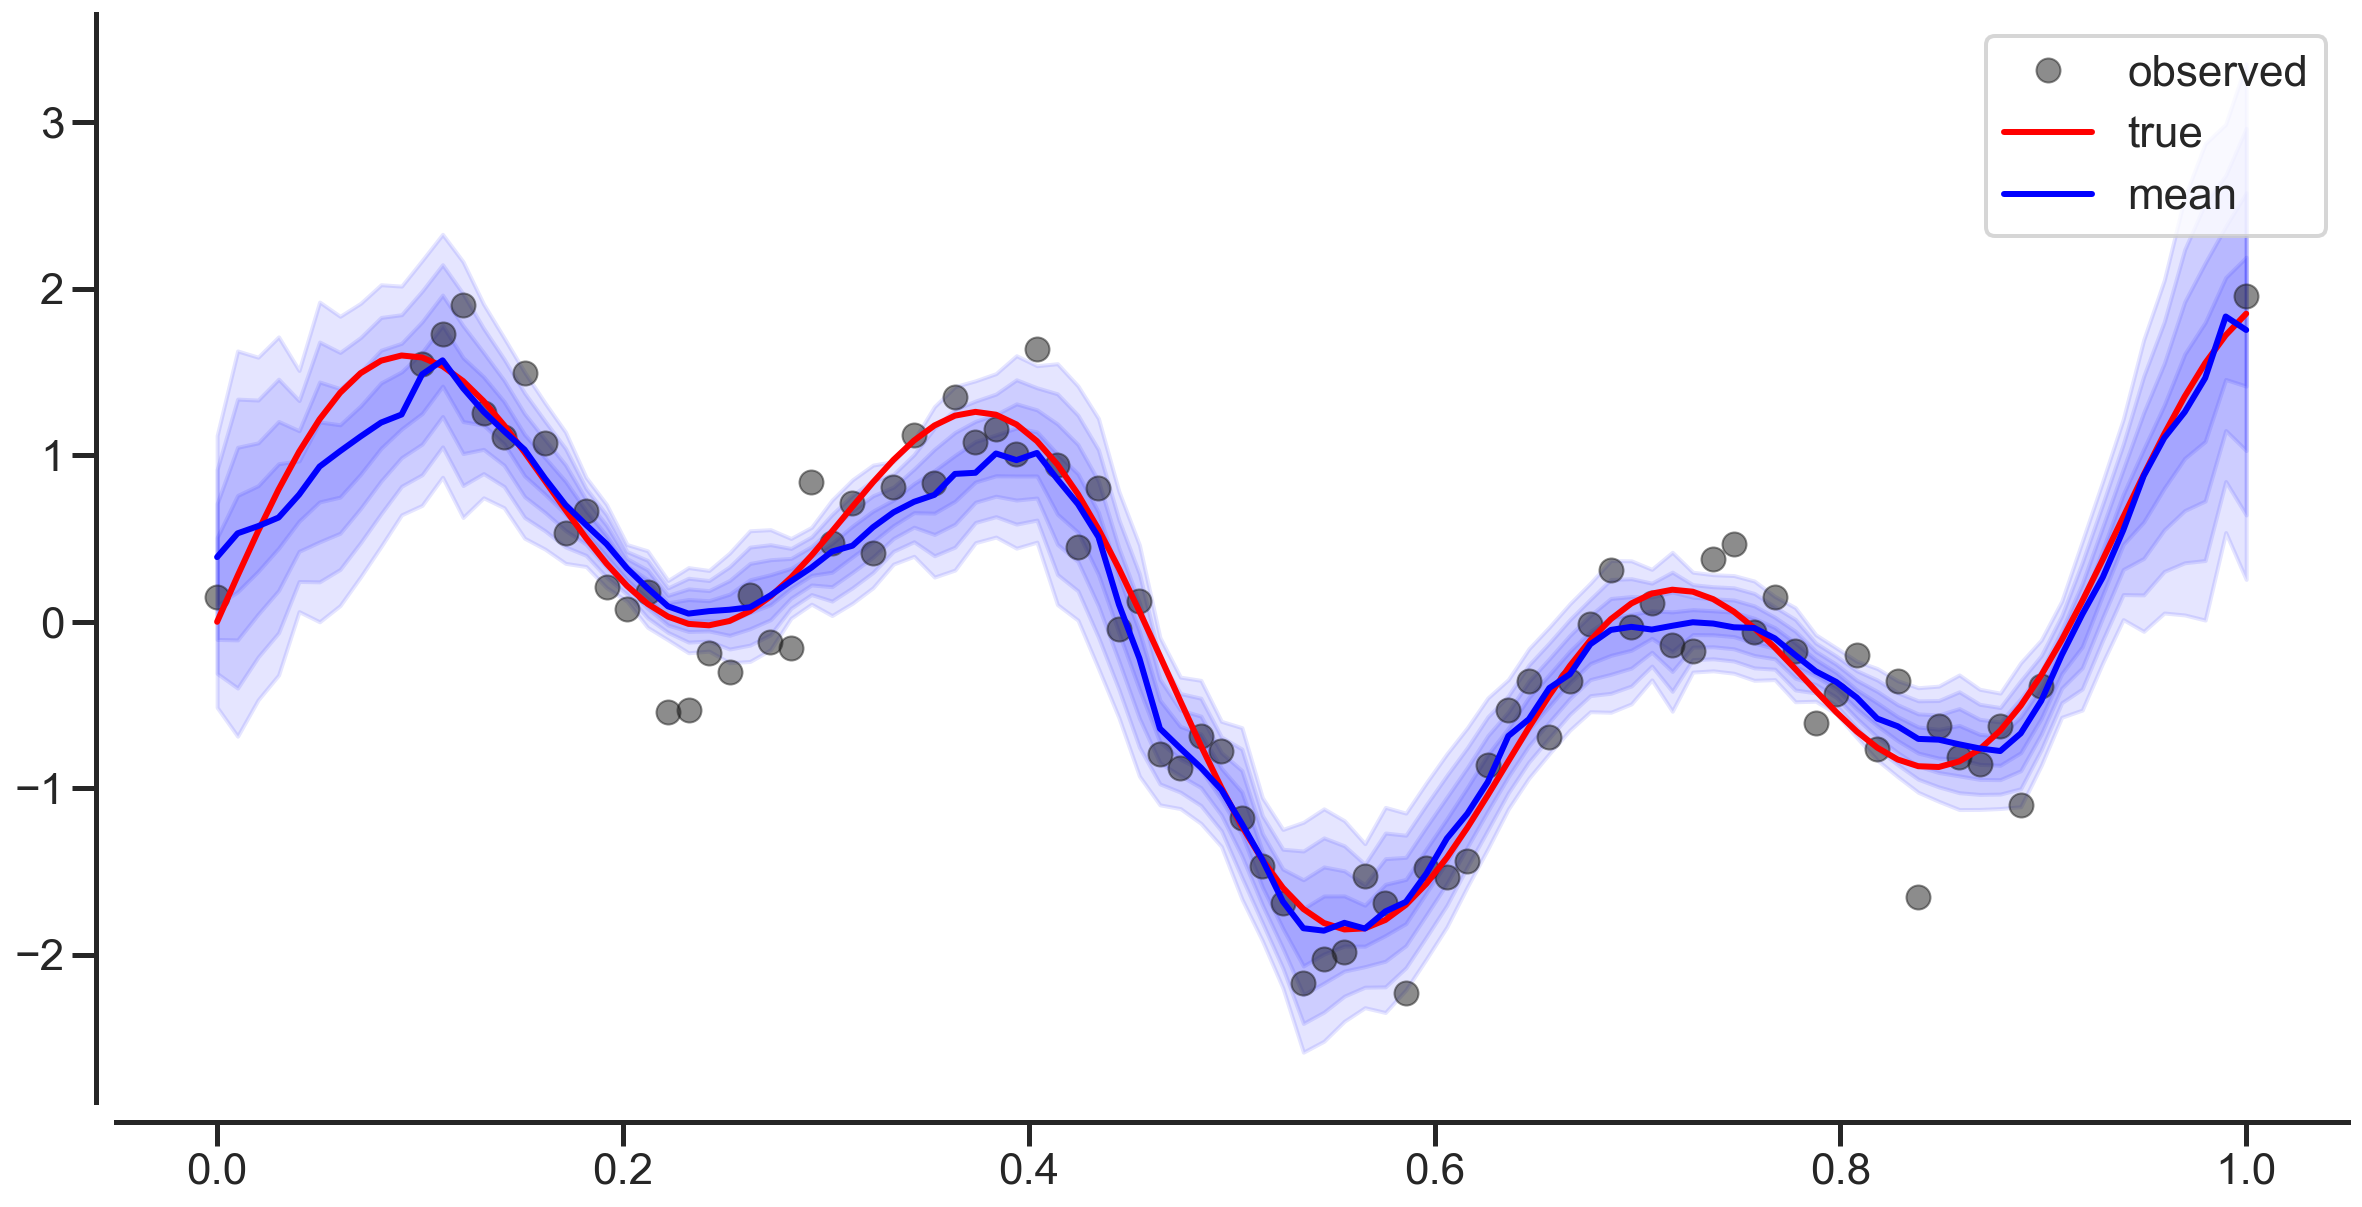

In [14]:
#raw uncretainty from ensemble

fig, ax = plt.subplots(1,1)
y_mean, y_std = model.uncertainty_function(X_long, iters, l2=l2)
y_mean_raw, y_std_raw = model.uncertainty_function(X_long, iters, l2=l2,raw_var=True)


ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_long, y_long, ls="-", color="r", label="true")
ax.plot(X_long, y_mean, ls="-", color="b", label="mean")


    
    
for i in range(n_std):
    ax.fill_between(
        X_long.squeeze(),
        y_mean_raw.squeeze() - y_std_raw.squeeze() * ((i+1)/2),
        y_mean_raw.squeeze() + y_std_raw.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
    
ax.legend()
sns.despine(offset=10)

# Ensembles


In [15]:
 
    
from models import VanillaEnsemble


In [16]:
vanilla = VanillaEnsemble(dataset_lenght = len(X))

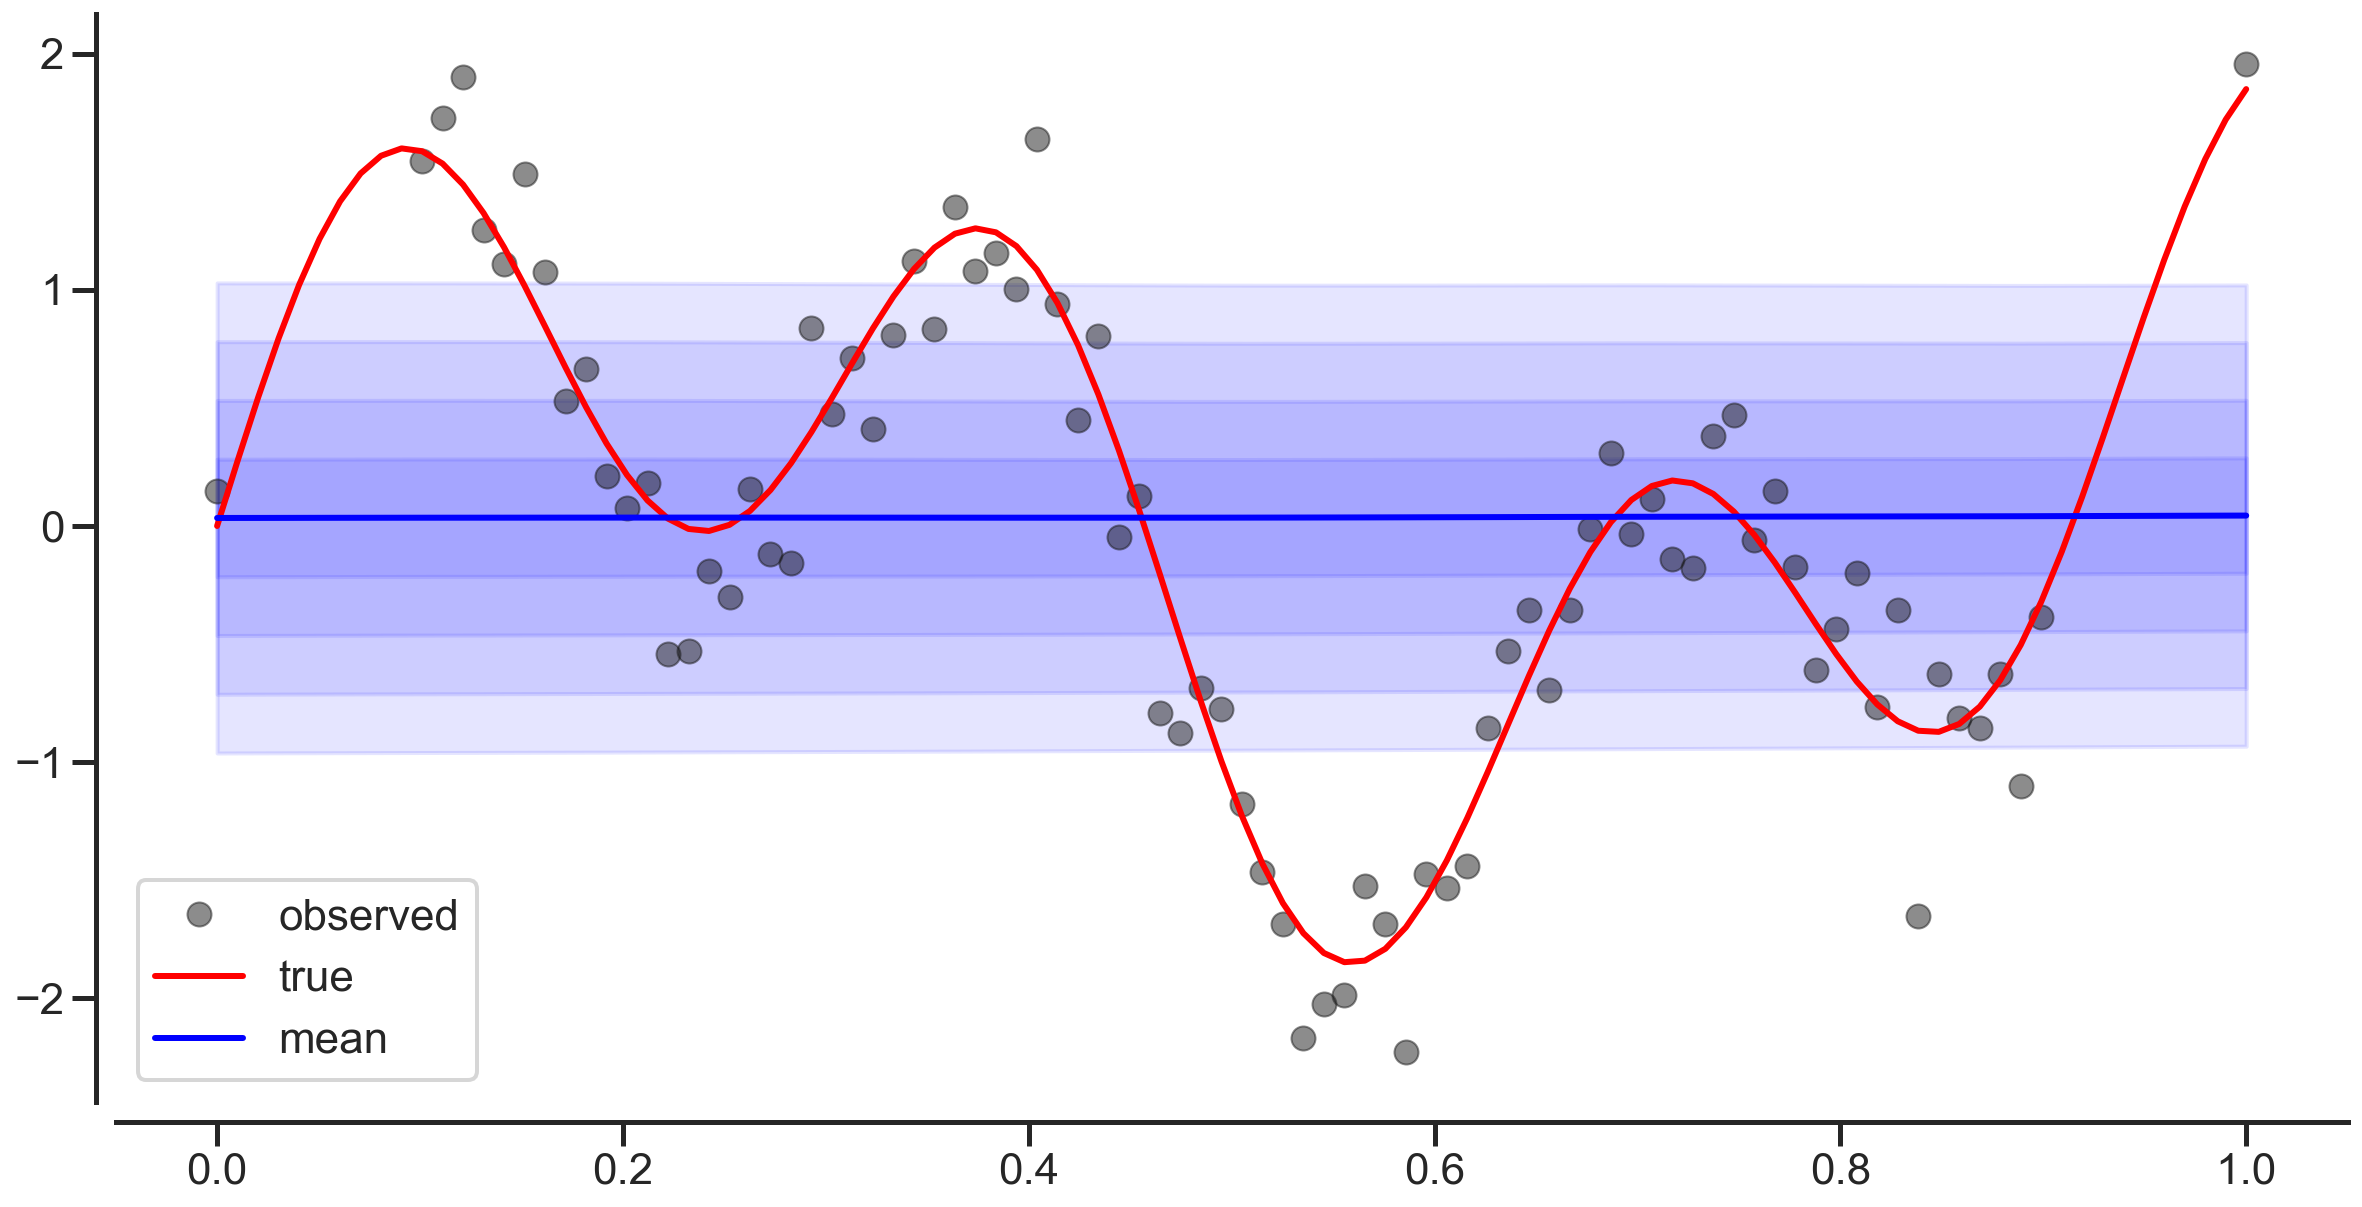

In [17]:
fig, ax = plt.subplots(1,1)
y_mean, y_std = vanilla.uncertainty_function(X_long, iters, l2=l2)
#y_mean_raw, y_std_raw = vanilla.uncertainty_function(X_long, iters, l2=l2,raw_var=True)


ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_long, y_long, ls="-", color="r", label="true")
ax.plot(X_long, y_mean, ls="-", color="b", label="mean")


    
    
for i in range(n_std):
    ax.fill_between(
        X_long.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
    
ax.legend()
sns.despine(offset=10)

In [18]:
for i in trange(epochs):

    vanilla.fit_model(X,y)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:19<00:00, 71.85it/s]


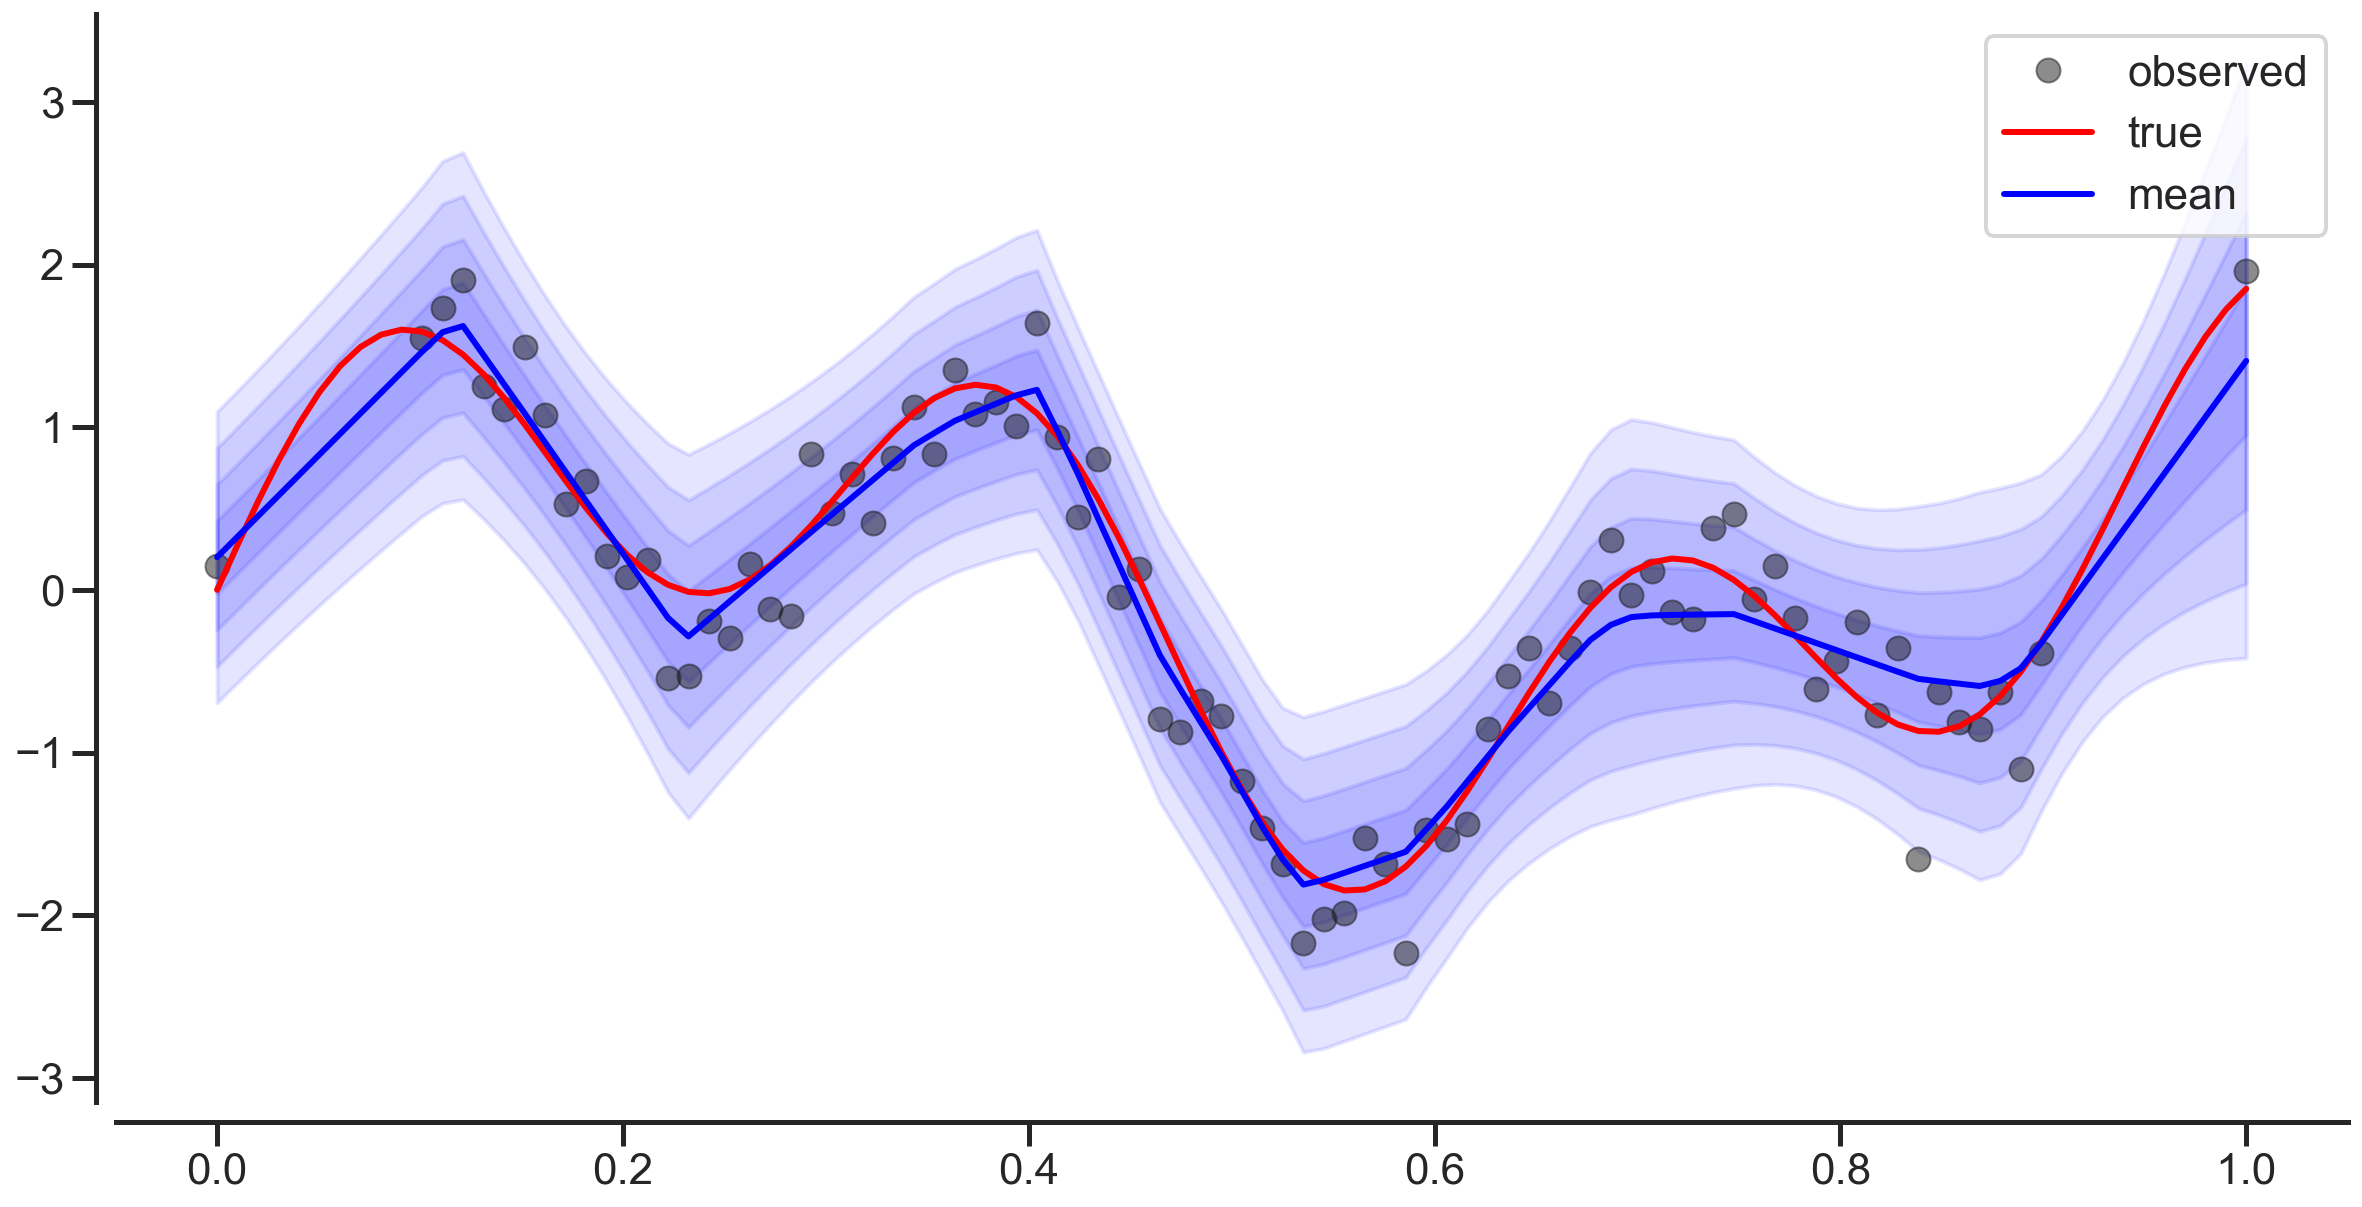

In [19]:
fig, ax = plt.subplots(1,1)
y_mean, y_std = vanilla.uncertainty_function(X_long, iters, l2=l2)
#y_mean_raw, y_std_raw = vanilla.uncertainty_function(X_long, iters, l2=l2,raw_var=True)


ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_long, y_long, ls="-", color="r", label="true")
ax.plot(X_long, y_mean, ls="-", color="b", label="mean")


    
    
for i in range(n_std):
    ax.fill_between(
        X_long.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
    
ax.legend()
sns.despine(offset=10)

## Shuffle Ensemble

In [20]:
from models import ShuffleEnsemble



In [21]:
shuffle = ShuffleEnsemble()

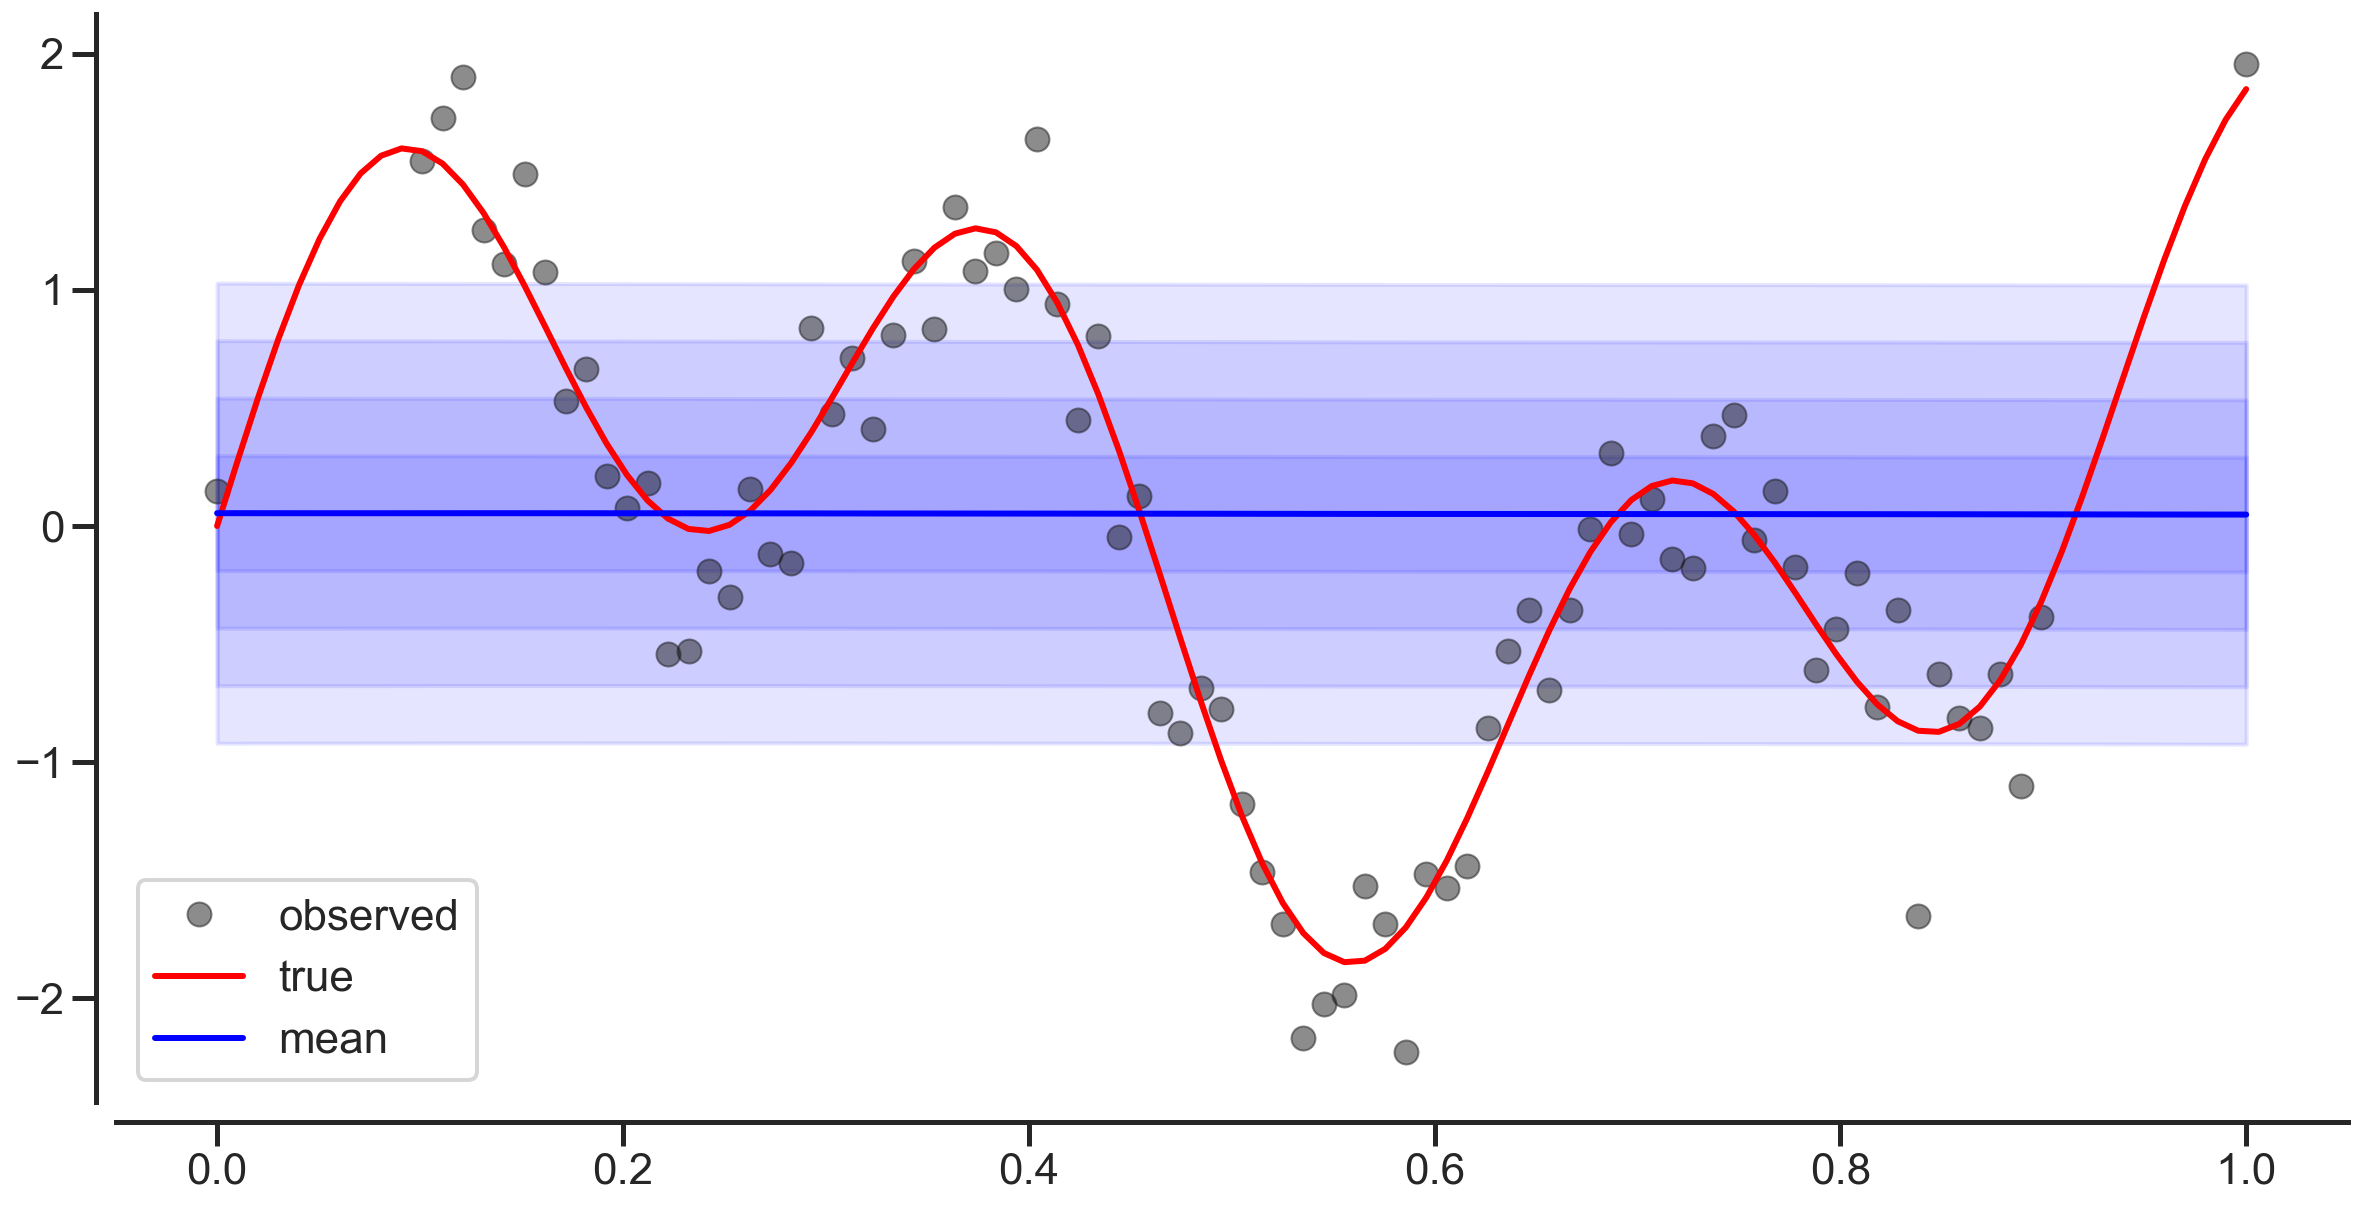

In [22]:
fig, ax = plt.subplots(1,1)
y_mean, y_std = shuffle.uncertainty_function(X_long, iters, l2=l2)
#y_mean_raw, y_std_raw = vanilla.uncertainty_function(X_long, iters, l2=l2,raw_var=True)


ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_long, y_long, ls="-", color="r", label="true")
ax.plot(X_long, y_mean, ls="-", color="b", label="mean")


    
    
for i in range(n_std):
    ax.fill_between(
        X_long.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
    
ax.legend()
sns.despine(offset=10)

In [23]:
for i in trange(epochs):

    shuffle.fit_model(X,y)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:30<00:00, 66.24it/s]


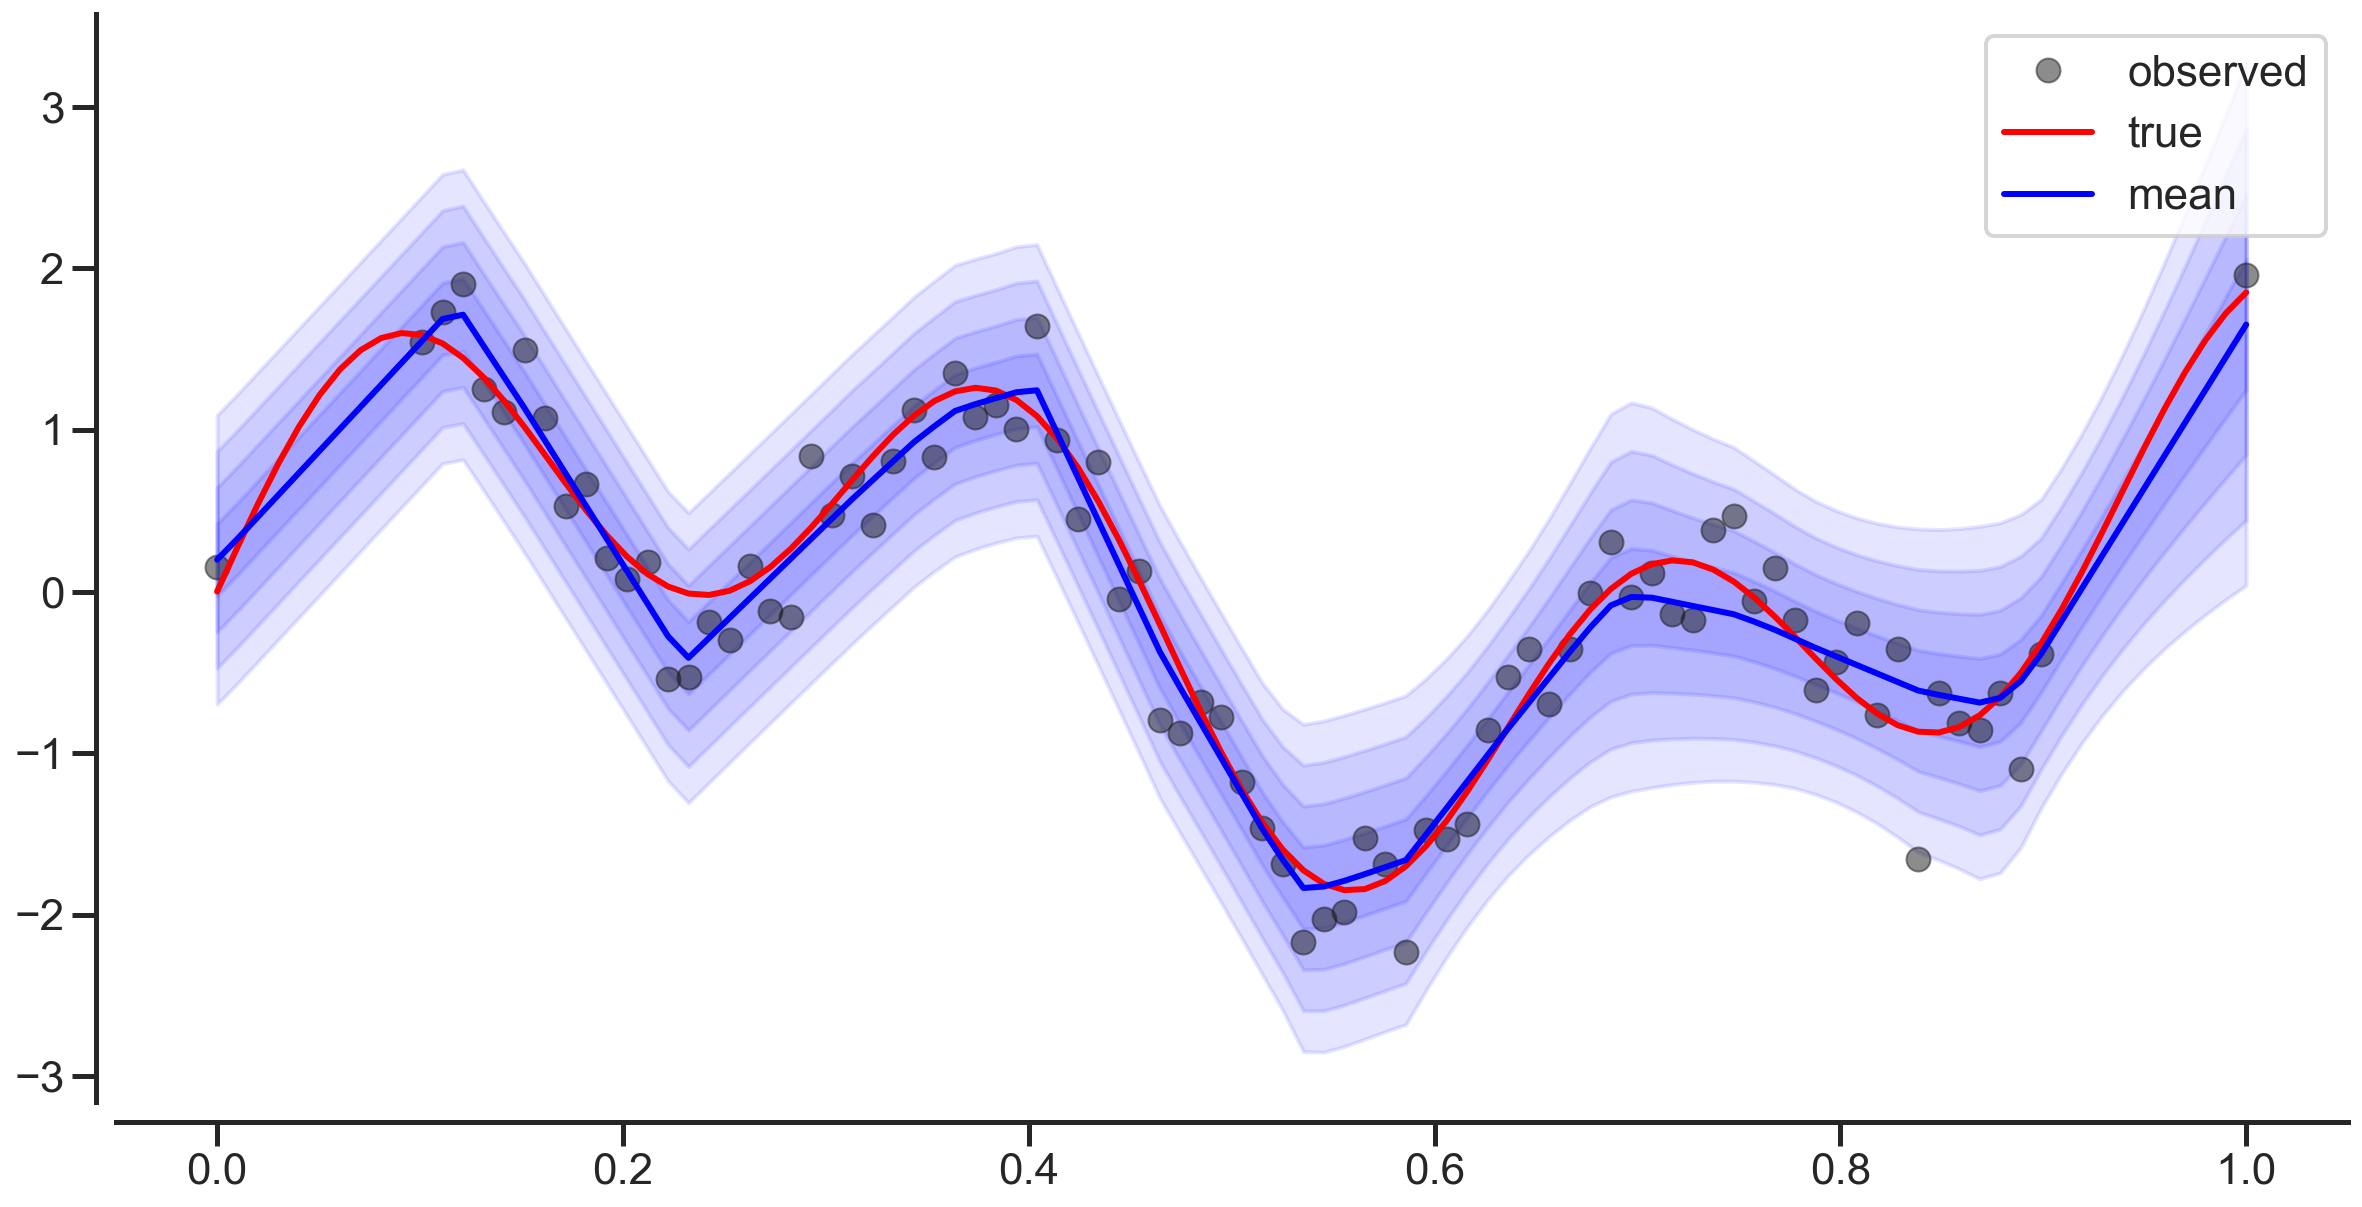

In [24]:
fig, ax = plt.subplots(1,1)
y_mean, y_std = shuffle.uncertainty_function(X_long, iters, l2=l2)
#y_mean_raw, y_std_raw = vanilla.uncertainty_function(X_long, iters, l2=l2,raw_var=True)


ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_long, y_long, ls="-", color="r", label="true")
ax.plot(X_long, y_mean, ls="-", color="b", label="mean")


    
    
for i in range(n_std):
    ax.fill_between(
        X_long.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
    
ax.legend()
sns.despine(offset=10)

## Bootstrapensemble

In [25]:
from models import BootstrapEnsemble


In [26]:
bootstrap = BootstrapEnsemble(dataset_lenght = len(X))

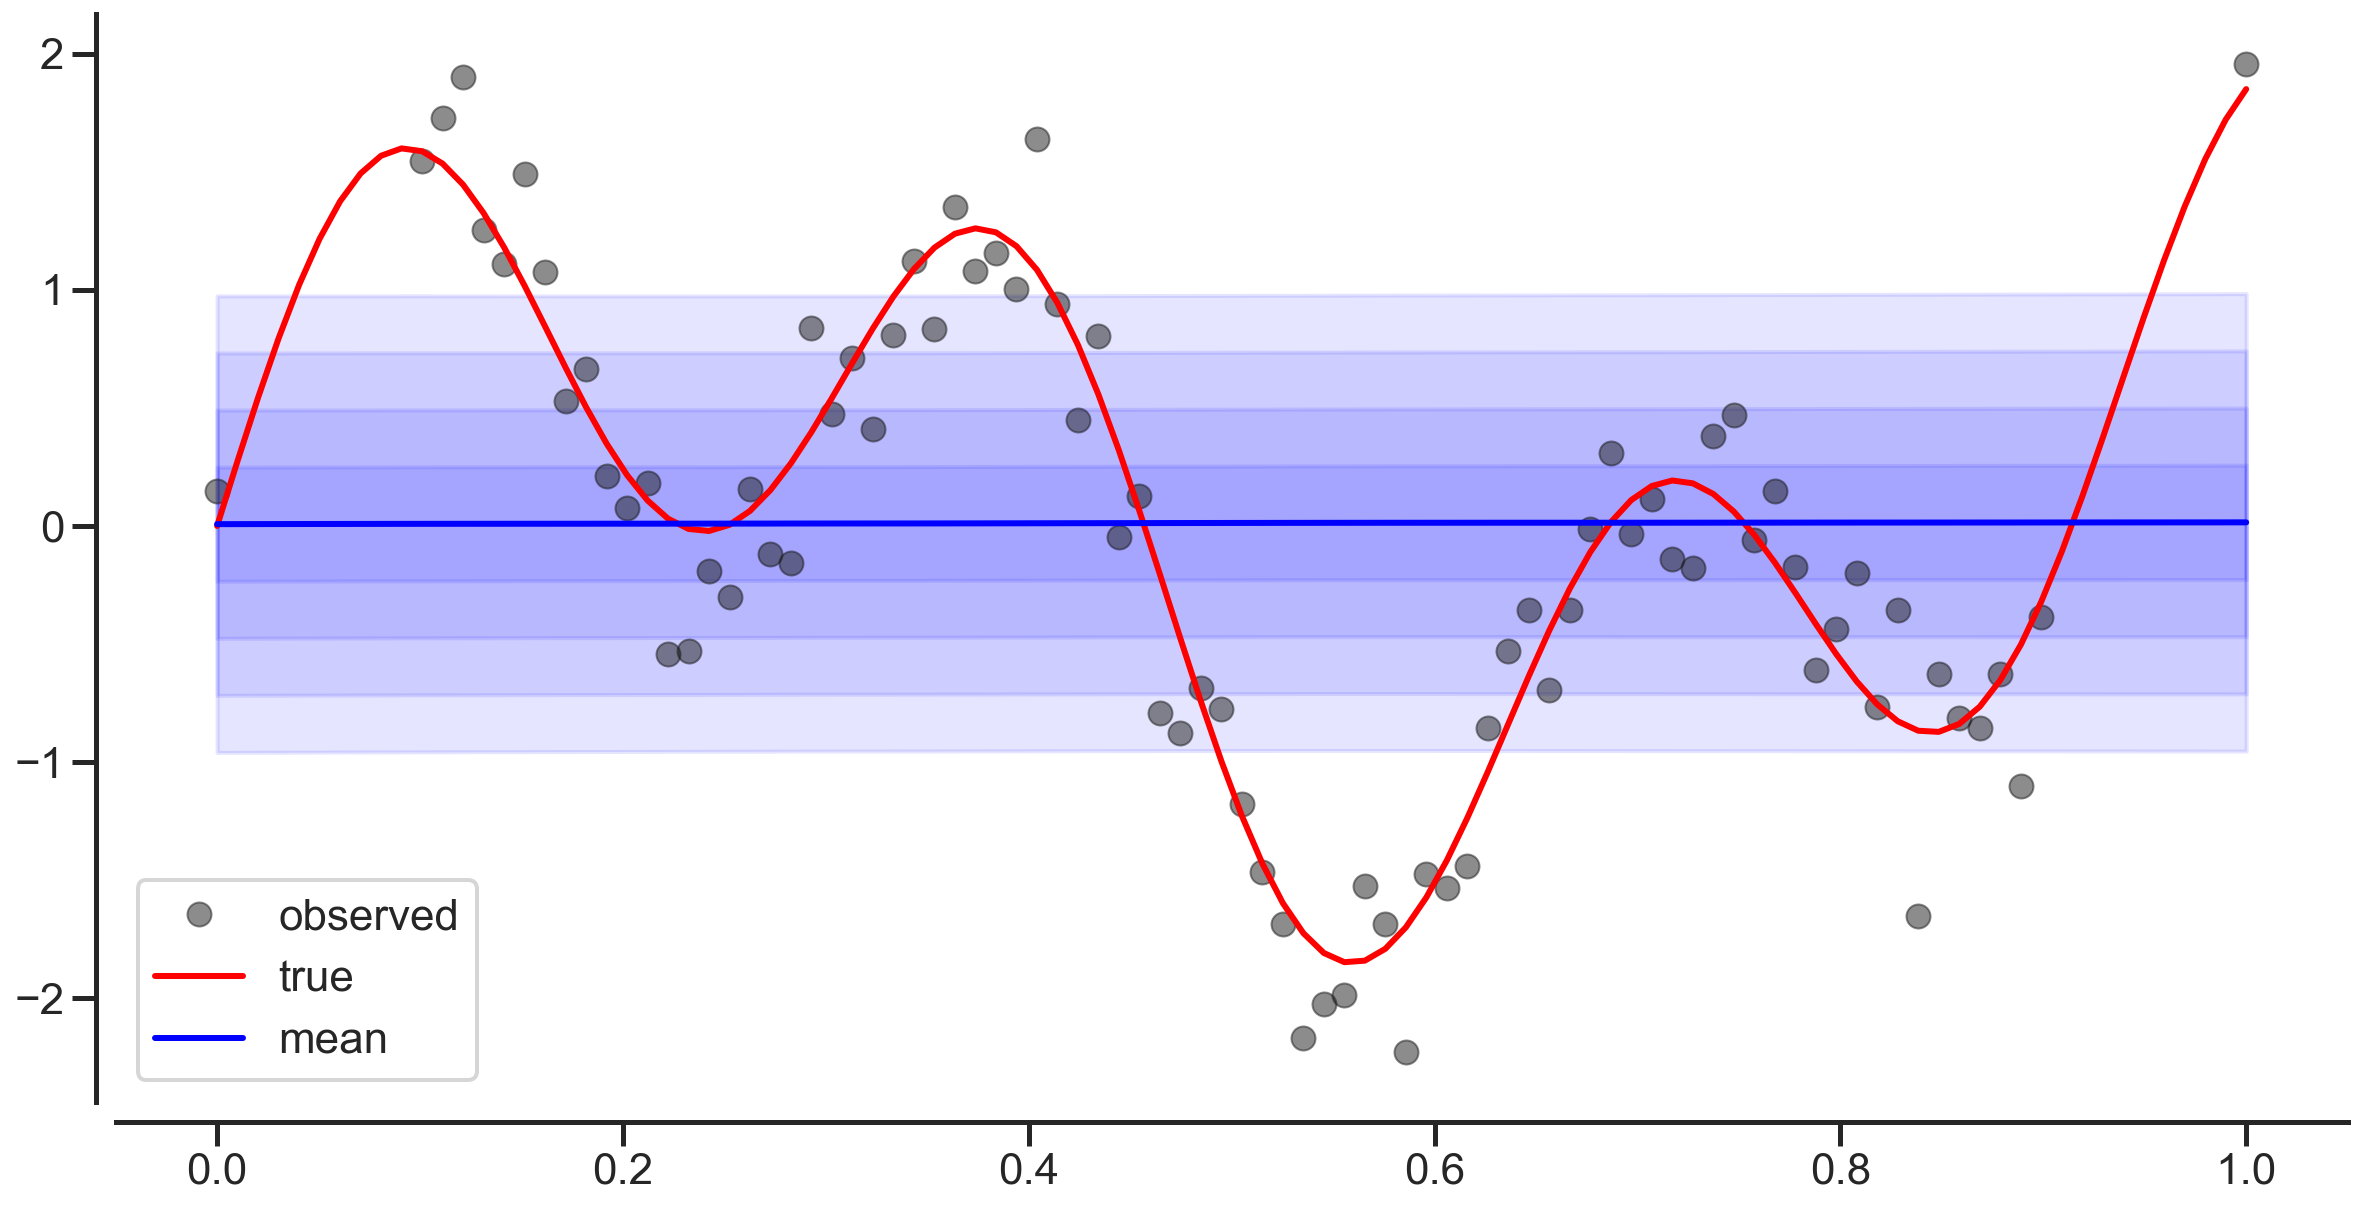

In [27]:
fig, ax = plt.subplots(1,1)
y_mean, y_std = bootstrap.uncertainty_function(X_long, iters, l2=l2)
#y_mean_raw, y_std_raw = vanilla.uncertainty_function(X_long, iters, l2=l2,raw_var=True)


ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_long, y_long, ls="-", color="r", label="true")
ax.plot(X_long, y_mean, ls="-", color="b", label="mean")


    
    
for i in range(n_std):
    ax.fill_between(
        X_long.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
    
ax.legend()
sns.despine(offset=10)

In [28]:
for i in trange(epochs):

    bootstrap.fit_model(X,y)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:30<00:00, 66.47it/s]


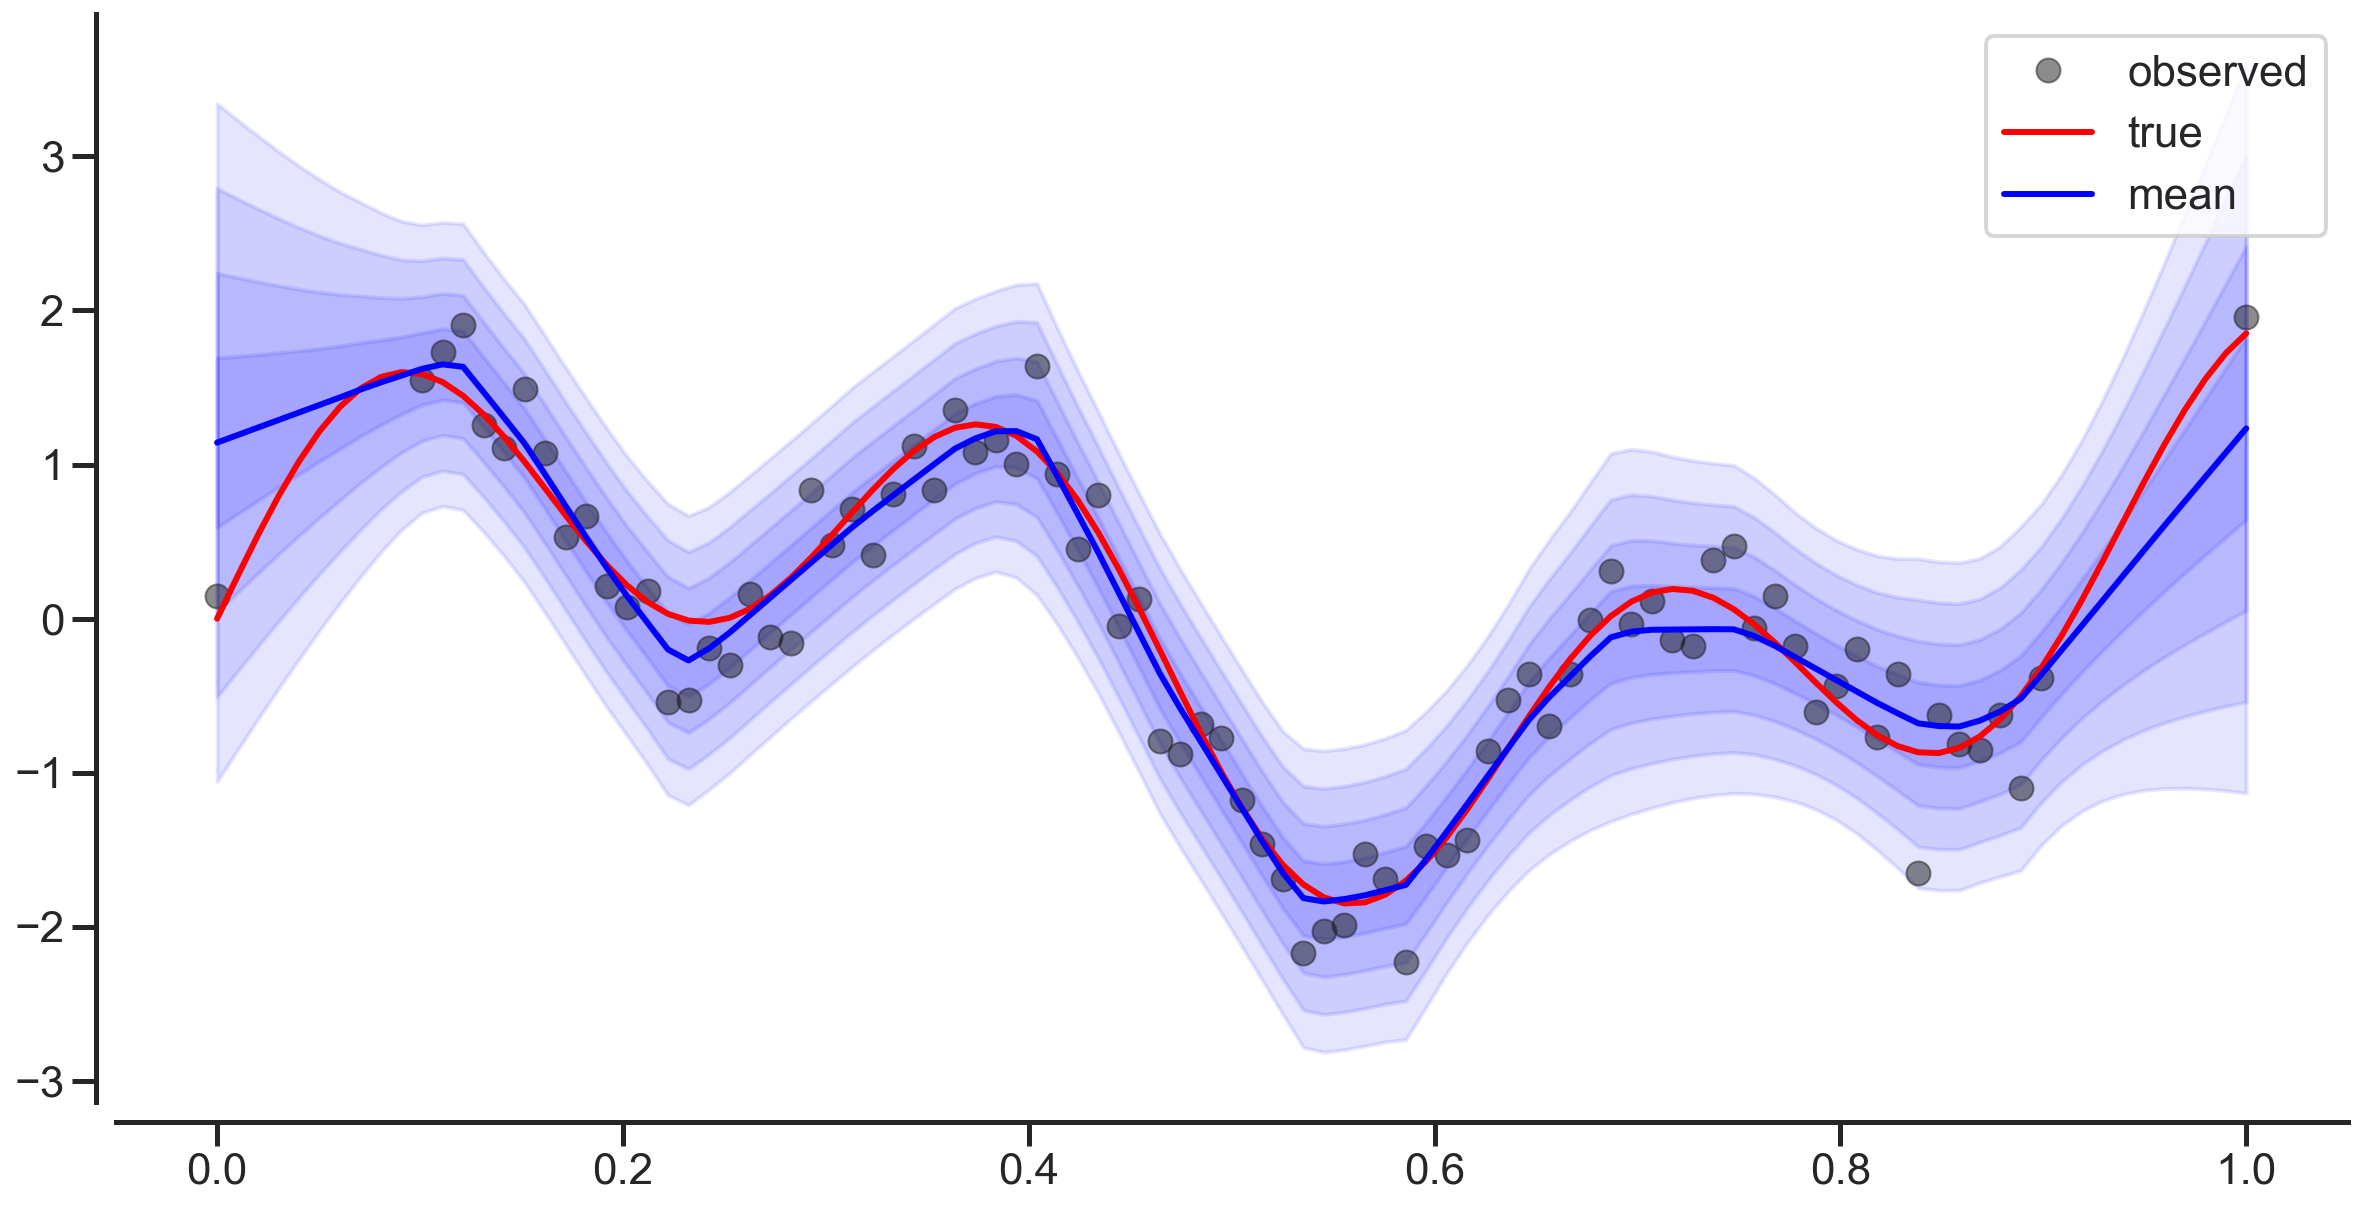

In [29]:
fig, ax = plt.subplots(1,1)
y_mean, y_std = bootstrap.uncertainty_function(X_long, iters, l2=l2)
#y_mean_raw, y_std_raw = vanilla.uncertainty_function(X_long, iters, l2=l2,raw_var=True)


ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_long, y_long, ls="-", color="r", label="true")
ax.plot(X_long, y_mean, ls="-", color="b", label="mean")


    
    
for i in range(n_std):
    ax.fill_between(
        X_long.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
    
ax.legend()
sns.despine(offset=10)